Задача: выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor
Выбрать оптимальные параметры для каждого дерева.
Задача: обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для регрессора

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score
from sklearn.datasets import load_iris

In [3]:
iris = load_iris()
iris.feature_names
X = iris.data[:, 2:]
target_names = iris.target_names
feature_names = iris.feature_names[2:]

y = iris.target

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.6, 0.5, 'x[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

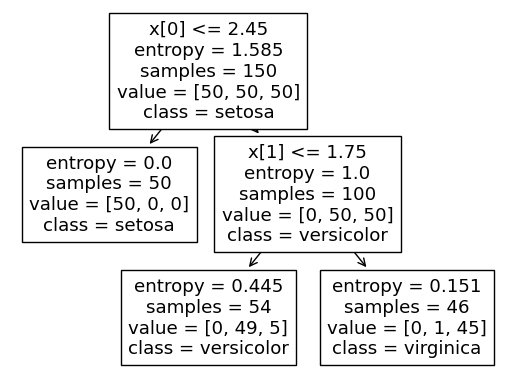

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# criterion: “gini”, “entropy”, “log_loss”. default=”gini”
tree_clf_gini = DecisionTreeClassifier(criterion = 'entropy',max_depth=2, random_state=42)
tree_clf_gini.fit(X, y)
tree.plot_tree(tree_clf_gini, class_names = target_names)

обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе.
визуализируйте MAE

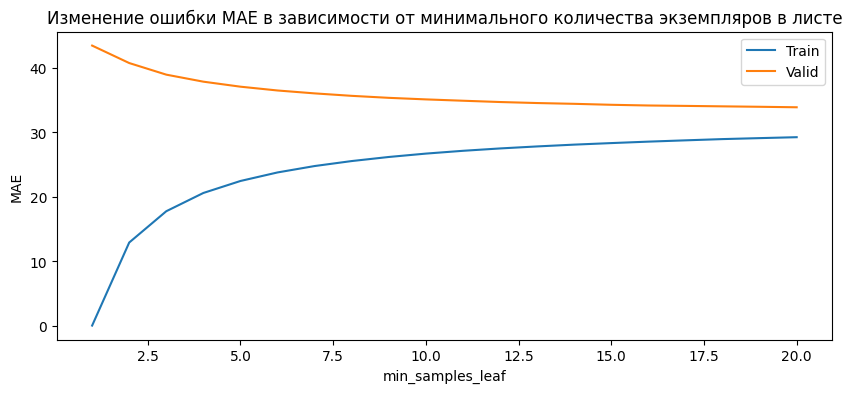

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

train = pd.read_csv('./departure-delayed/train_features.csv').fillna(0)
y = pd.read_csv('./departure-delayed/train_target.csv', index_col='id')


types = train.dtypes
real_cols = list(types[types != 'object'].index.values)

x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

mae_train = []
mae_val = []

for i in range(1, 21):
    dt = DecisionTreeRegressor(min_samples_leaf=i)
    dt.fit(x_train[real_cols], y_train)

    mae_train.append(mean_absolute_error(dt.predict(x_train[real_cols]), y_train))
    mae_val.append(mean_absolute_error(dt.predict(x_val[real_cols]), y_val))


plt.figure(figsize=(10, 4))
plt.title('Изменение ошибки MAE в зависимости от минимального количества экземпляров в листе')
plt.plot(range(1, 21), mae_train, label='Train')
plt.plot(range(1, 21), mae_val, label='Valid')
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('MAE')
plt.show()


обучите дерево с наилучшими параметрами из предыдущего примера

In [7]:
best_min_samples_leaf = np.argmin(mae_val) + 1
print(f"Наилучшее значение min_samples_leaf: {best_min_samples_leaf}")

# Обучаем модель с лучшими параметрами
best_dt = DecisionTreeRegressor(min_samples_leaf=best_min_samples_leaf)
best_dt.fit(x_train[real_cols], y_train)

mae_val_best = mean_absolute_error(best_dt.predict(x_val[real_cols]), y_val)

print(f"MAE на валидационной выборке с лучшими параметрами: {mae_val_best}")

Наилучшее значение min_samples_leaf: 20
MAE на валидационной выборке с лучшими параметрами: 33.840463279225666


Задача. Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.

Визуализировать графики зависимости предсказания от параметров модели.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from datasets import load_dataset
import nltk
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop_words = stopwords.words('english')

dataset = load_dataset('json', data_files={'train': 'train.jsonl', 'test': 'validation.jsonl'})

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stop_words)
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])
X_test_vec = vectorizer.transform(dataset['test']['text'])

tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)
X_test_idf = tfidf.transform(X_test_vec)

X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()
y_train = np.array(dataset['train']['label'])
y_test = np.array(dataset['test']['label'])


X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fbidn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Generating train split: 16000 examples [00:00, 1578586.38 examples/s]
Generating test split: 2000 examples [00:00, 332090.58 examples/s]


In [11]:
N = 10
estimators_range = [2, 5, 10, 20]
depth_range = [2, 4, 6, 8]


def make_blending_prediction(basic_clfs, final_clf, data):
    y0 = np.hstack([c.predict_proba(data)[:, 1].reshape(-1, 1) for c in basic_clfs])
    return final_clf.predict(y0)

def make_stacking_prediction(basic_clfs, final_clf, data):
    y0 = np.hstack([c.predict_proba(data)[:, 1].reshape(-1, 1) for c in basic_clfs])
    return final_clf.predict(y0)

In [12]:
#блэндинг

blending_results = []
for n_estimators in estimators_range:
    for max_depth in depth_range:
        crf = []
        y_pred_1 = []

        for n in range(1, N + 1):
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=n)
            clf.fit(X_train_0, y_train_0)
            crf.append(clf)
            y_pred_1.append(clf.predict_proba(X_train_1)[:, 1].reshape(-1, 1))

        y_pred_1t = np.hstack(y_pred_1)
        clf_final = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
        clf_final.fit(y_pred_1t, y_train_1)

        y_test_pred = make_blending_prediction(crf, clf_final, X_test)
        acc = accuracy_score(y_test, y_test_pred)
        blending_results.append((n_estimators, max_depth, acc))


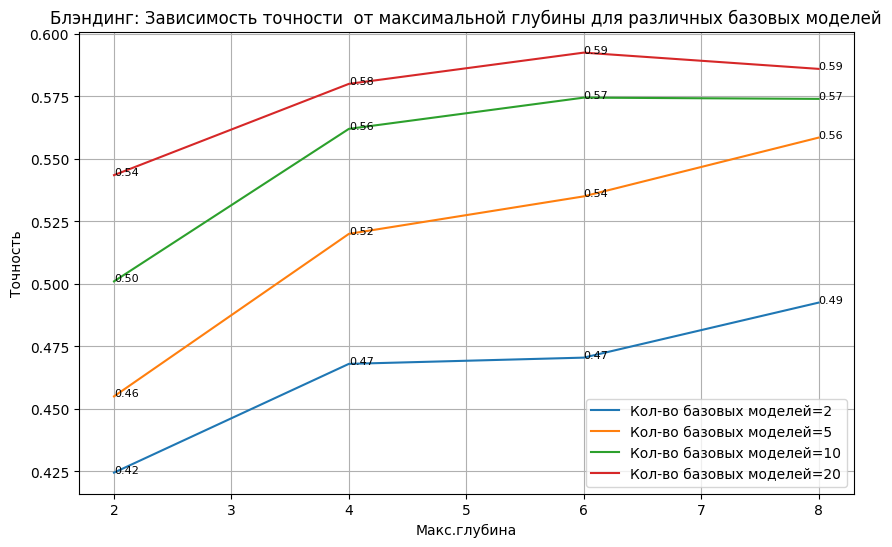

In [13]:
plt.figure(figsize=(10, 6))
for n_estimators in estimators_range:
    accuracies = [acc for est, depth, acc in blending_results if est == n_estimators]
    plt.plot(depth_range, accuracies, label=f'Кол-во базовых моделей={n_estimators}')
    for depth, acc in zip(depth_range, accuracies):
        plt.text(depth, acc, f'{acc:.2f}', fontsize=8)
plt.xlabel('Макс.глубина')
plt.ylabel('Точность')
plt.title('Блэндинг: Зависимость точности  от максимальной глубины для различных базовых моделей')
plt.legend()
plt.grid()
plt.show()

In [14]:
#стэкинг
stacking_results = []
kf = KFold(n_splits=N, shuffle=True, random_state=42)

for n_estimators in estimators_range:
    for max_depth in depth_range:
        crf_stack = []
        pre_prediction = np.zeros((len(X_train), N))

        for i, (train_idx, test_idx) in enumerate(kf.split(X_train)):
            X_train_0, X_test_1 = X_train[train_idx], X_train[test_idx]
            y_train_0, y_test_1 = y_train[train_idx], y_train[test_idx]

            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=i)
            clf.fit(X_train_0, y_train_0)
            crf_stack.append(clf)
            pre_prediction[test_idx, i] = clf.predict_proba(X_test_1)[:, 1]

        clf_stack_final = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
        clf_stack_final.fit(pre_prediction, y_train)

        y_test_pred = make_stacking_prediction(crf_stack, clf_stack_final, X_test)
        acc = accuracy_score(y_test, y_test_pred)
        stacking_results.append((n_estimators, max_depth, acc))

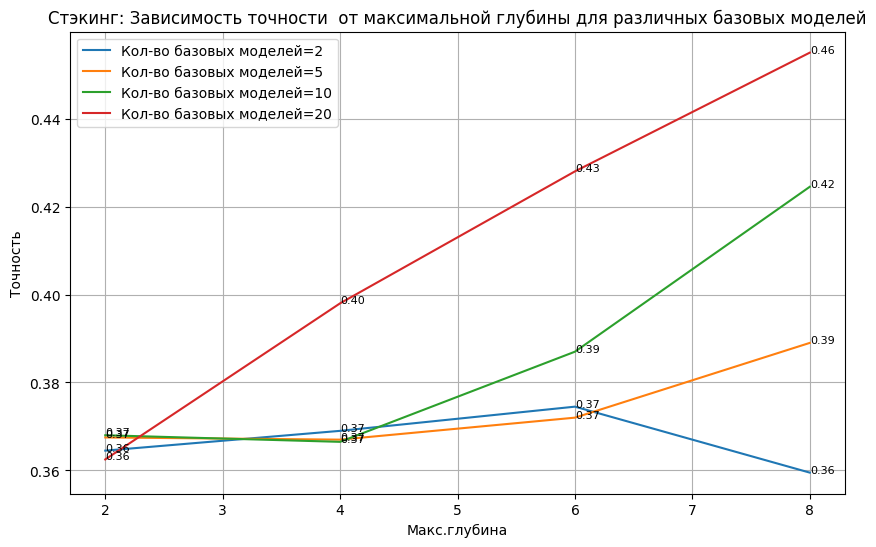

In [15]:
plt.figure(figsize=(10, 6))
for n_estimators in estimators_range:
    accuracies = [acc for est, depth, acc in stacking_results if est == n_estimators]
    plt.plot(depth_range, accuracies, label=f'Кол-во базовых моделей={n_estimators}')
    for depth, acc in zip(depth_range, accuracies):
        plt.text(depth, acc, f'{acc:.2f}', fontsize=8)
plt.xlabel('Макс.глубина')
plt.ylabel('Точность')
plt.title('Стэкинг: Зависимость точности  от максимальной глубины для различных базовых моделей')
plt.legend()
plt.grid()
plt.show()